In [1]:
data = [(812.7776091308593, 823.6864184570312, 834.6565435791016, 825.2620681762695, 52190.227313476564, 53170.9026953125, 59358.99381835938, 59358.99381835938), (1564.2166639404297, 1640.0660144042968, 1647.7071767219654, 1541.7148034413663, 126597.43390820312, 139609.021953125, -38291.87075195314, 135107.7339355469), (2060.7491631469725, 2132.05138671875, 2155.640736728495, 2041.2696765899675, 179904.46500585938, 193369.469140625, -287476.93506835937, 186393.6233105469), (2716.8416154785155, 2734.665380859375, 2859.5269862980936, 2691.8439868927017, 272014.14705078123, 265128.65609375, -653866.4543457032, 328153.77081054694), (3559.7346801757812, 3395.4784521484376, 3656.165223850538, 3479.143819554649, 451864.708109375, 415650.5540625, -1222999.3323925782, 514536.9376855471), (4111.518697265625, 3943.7013720703126, 4170.997998196673, 3951.653803888958, 578083.37996875, 512397.635, -2145520.3261816404, 630381.2570605472), (4553.637655517578, 4502.204418945313, 4745.259790131884, 4518.850072606404, 685519.2051875, 692237.51625, -3282366.7317871093, 708159.7058105471), (5424.3938876953125, 5632.648051757813, 5485.207055721042, 5297.6789707183825, 947395.949015625, 1054189.0125, -4962573.170361327, 1134377.2895605469), (6070.173527587891, 5910.2733544921875, 6122.124066971902, 5897.396896743774, 1168115.584796875, 1137705.124375, -6929772.651298827, 1355649.4220605465), (6819.292000732422, 6804.12009765625, 7016.370967501528, 6783.249476496376, 1437360.74984375, 1432093.665, -8943481.539580077, 1947697.1570605463), (7423.453934326172, 7544.571162109375, 7640.976421647014, 7369.759882990517, 1712647.99315625, 1810546.346875, -11805276.223251954, 2217114.674560547), (7926.604189697266, 7848.681220703125, 8035.80862962419, 7799.754552586869, 1915972.90515625, 1897719.2425, -14628392.972626952, 2549569.8458105456), (8934.243265136718, 9689.875595703124, 9013.703722476743, 8923.500117365518, 2345699.1895625, 2841537.85875, -19368738.182314456, 2101418.208310547), (9517.955543945312, 9538.040078125, 9665.30002037525, 9655.374384943641, 2649671.8879375, 2727777.825, -23344119.70793945, 2409008.3133105473), (10058.86715625, 10320.79921875, 10266.415192062837, 10184.39927711487, 2957965.10559375, 3002429.6825, -28161995.92481446, 2942446.0983105483), (11093.817899414062, 10907.253232421876, 11046.358699883587, 11067.110692723598, 3558380.8425625, 3497583.435, -33627503.95106446, 3307031.383310548), (12002.893725097656, 12449.14662109375, 12028.36065015934, 12155.465215428676, 4274513.1050625, 4492632.23, -40936585.37481446, 4010981.4433105486), (12499.94040234375, 12136.855869140625, 12739.14486582608, 12779.468511327115, 4606202.7714375, 4230106.1725, -49974524.69646485, 4516325.450810551), (13261.991238769531, 13298.475341796875, 13375.676175471115, 13450.936691665653, 5129581.3066875, 5163543.685, -58947205.76068361, 4450110.845810551), (13697.920624511718, 13731.5766796875, 13872.871212777409, 13923.140315119428, 5492684.45675, 5984520.445, -69044319.2644336, 4813224.143310553), (14380.46032861328, 14290.337001953125, 14522.005575088153, 15110.59302734375, 5945950.99075, 5873111.4825, -78909633.4675586, 4327410.478310551), (15030.968162597655, 15544.23107421875, 15384.66013230372, 15802.573170572918, 6389091.8735, 6879633.295, -92726136.06693354, 3071196.8233105512), (15969.947152832032, 17834.298046875, 16516.603862226184, 16892.762277832036, 7263657.234375, 9177016.82, -104383302.13173828, 3565918.7733105496), (16508.54742480469, 16390.0664453125, 16927.339619634007, 17404.553781738283, 7602925.3555, 7903066.345, -118392163.26798826, 4700281.883310549), (17322.393390625, 16999.28177734375, 17382.15294800708, 17976.790008138025, 8303054.08, 8097037.695, -135837793.8354883, 6721376.383310551), (18139.638240234373, 18610.8790625, 17953.29517161014, 18613.96914632161, 9177168.096375, 9718710.06, -157191702.8867383, 6390076.543310554), (18415.77846875, 18146.08345703125, 18719.453085653873, 19301.252532552076, 9435503.6745, 8931019.3125, -179998006.80673835, 5354562.103310555), (19126.382688476562, 19288.21837890625, 19285.57176379818, 19779.77338623048, 10179226.407375, 10612930.84, -198410850.83423838, 4757339.543310553), (20232.33291699219, 20427.238359375, 20126.315877854053, 20593.316578776048, 11374036.3175, 11521245.645, -218414595.59455097, 7002635.363310553)]

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
correct_trace = []
hutchinson = []
delta_shift = []
delta_shift_r = []

correct_norm = []
hutchinson_norm = []
bad_norm = []
delta_shift_norm = []

for i in data:
    correct_trace.append(i[0])
    hutchinson.append(i[1])
    delta_shift.append(i[2])
    delta_shift_r.append(i[3])
    correct_norm.append(i[4])
    hutchinson_norm.append(i[5])
    bad_norm.append(i[6])
    delta_shift_norm.append(i[7])

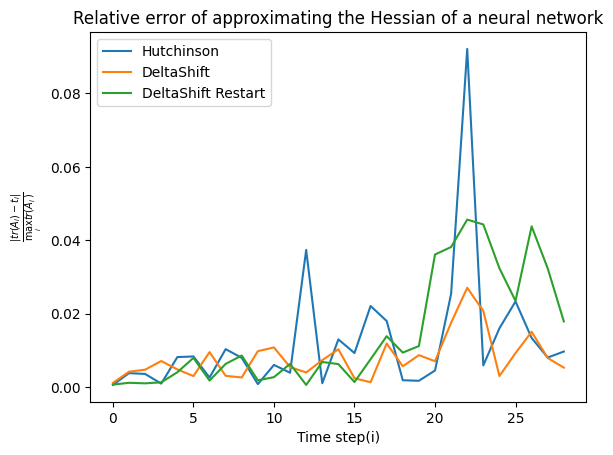

In [12]:
x = np.arange(len(hutchinson))

plt.plot(x, np.abs(np.array(correct_trace) - np.array(hutchinson)) / max(correct_trace), label="Hutchinson")
plt.plot(x, np.abs(np.array(correct_trace) - np.array(delta_shift)) / max(correct_trace), label="DeltaShift")
plt.plot(x,  np.abs(np.array(correct_trace) - np.array(delta_shift_r)) / max(correct_trace), label="DeltaShift Restart")

plt.legend()
plt.xlabel("Time step(i)")
plt.ylabel("$\\frac{|tr(A_i) - t_i|}{\max_i tr(A_i)}$")
plt.title("Relative error of approximating the Hessian of a neural network")

plt.show()

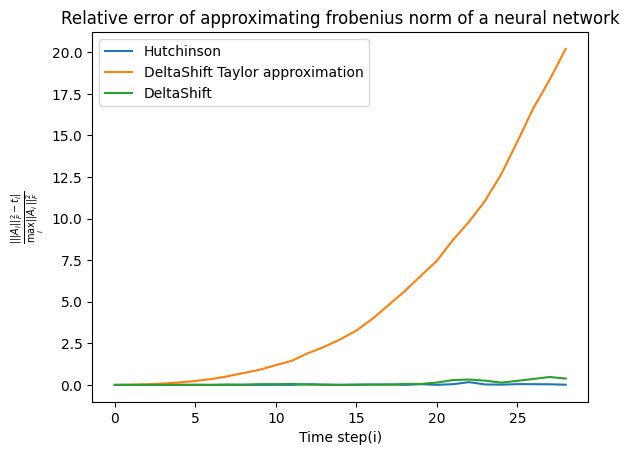

In [13]:
x = np.arange(len(hutchinson))

plt.plot(x, np.abs(np.array(correct_norm) - np.array(hutchinson_norm)) / max(correct_norm), label="Hutchinson")
plt.plot(x, np.abs(np.array(correct_norm) - np.array(bad_norm)) / max(correct_norm), label="DeltaShift Taylor approximation")
plt.plot(x,  np.abs(np.array(correct_norm) - np.array(delta_shift_norm)) / max(correct_norm), label="DeltaShift")

plt.legend()
plt.xlabel("Time step(i)")
plt.ylabel("$\\frac{| ||A_i||_F^2 - t_i |}{\max_i ||A_i||_F^2}$")
plt.title("Relative error of approximating frobenius norm of a neural network")

plt.show()

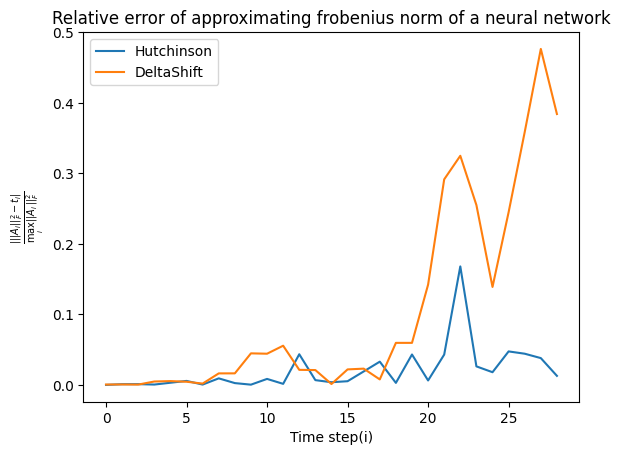

In [14]:
n = len(correct_norm)
x = np.arange(n)

plt.plot(x, np.abs(np.array(correct_norm[:n]) - np.array(hutchinson_norm[:n])) / max(correct_norm[:n]), label="Hutchinson")
plt.plot(x,  np.abs(np.array(correct_norm[:n]) - np.array(delta_shift_norm[:n])) / max(correct_norm[:n]), label="DeltaShift")

plt.legend()
plt.xlabel("Time step(i)")
plt.ylabel("$\\frac{| ||A_i||_F^2 - t_i |}{\max_i ||A_i||_F^2}$")
plt.title("Relative error of approximating frobenius norm of a neural network")

plt.show()